# This notebook is prepared on Kaggle kernel for submission to the Dphi practice challenge on the following link: https://dphi.tech/challenges/data-sprint-91-pharmaceutical-drug-recognition/296/overview/about

# Import the required packages

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
os.environ['PYTHONHASHSEED'] = str(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
random.seed(1)
np.random.seed(1)
# tf.random.set_seed(1)
tf.compat.v1.set_random_seed(1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import tensorflow_addons as tfa
import gc

# Path names

In [3]:
train_image_path = '../input/pharma-drug-image-classification/train'
test_image_path = '../input/pharma-drug-image-classification/test'
train_csv_path = '../input/pharma-drug-image-classification/Training_set.csv'
test_csv_path = '../input/pharma-drug-image-classification/Testing_set.csv'

# Plot a few images of train data

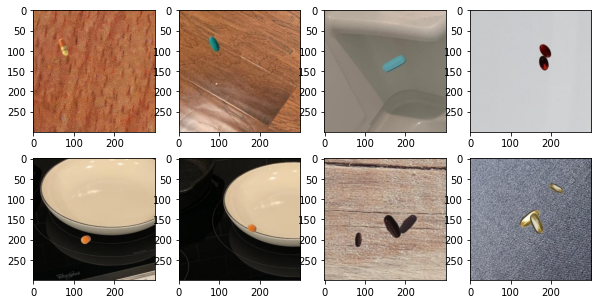

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
src_path = train_image_path
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

# Load the Pandas DataFrames

In [5]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Initialize Keras’ ImageDataGenerator class

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        horizontal_flip=True,
        validation_split=0.15)

test_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        horizontal_flip=True,
)

# Initialize the training, validation and testing generators by providing it the files directory and filename dataframe

In [8]:
batch_size = 32
target_size = 300
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="filename",
    y_col="label",
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="filename",
    y_col="label",
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_path,
    x_col="filename",
    target_size=(target_size, target_size),
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 5950 validated image filenames belonging to 10 classes.
Found 1050 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames.


# Create class dictionary for later use during submission

In [9]:
print(train_generator.class_indices)
class_names = {idx:name for name, idx in train_generator.class_indices.items()}
print(class_names)

{'Alaxan': 0, 'Bactidol': 1, 'Bioflu': 2, 'Biogesic': 3, 'DayZinc': 4, 'Decolgen': 5, 'Fish Oil': 6, 'Kremil S': 7, 'Medicol': 8, 'Neozep': 9}
{0: 'Alaxan', 1: 'Bactidol', 2: 'Bioflu', 3: 'Biogesic', 4: 'DayZinc', 5: 'Decolgen', 6: 'Fish Oil', 7: 'Kremil S', 8: 'Medicol', 9: 'Neozep'}


# Loss and Metric Plotting Functions

In [10]:
start = 0
def plot_loss(history_dict):
    key1 = list(history_dict.keys())[0]
    key2 = list(history_dict.keys())[2]
    loss_values = history_dict[key1][start:]
    val_loss_values=history_dict[key2][start:]
    plt.plot(loss_values,'b-',label=key1)
    plt.plot(val_loss_values,'r--',label=key2)
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

def plot_metric(history_dict):
    key1 = list(history_dict.keys())[1]
    key2 = list(history_dict.keys())[3]
    metric_values = history_dict[key1][start:]
    val_metric_values=history_dict[key2][start:]
    plt.plot(metric_values,'b-',label=key1)
    plt.plot(val_metric_values,'r--',label=key2)
    plt.title('Training vs Validation Metric')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

# Use pretrained model Xception from Keras library, remove the head of the model and declare the 10 required number of classes

In [11]:
pretrained_model = keras.applications.Xception(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=10,
                                            classifier_activation="softmax",
                                        )

83697664/83683744 [==============================] - 1s 0us/step


# We will train the entire model, therefore no need to freeze the layers of the pretrained model. We just flatten the convolutional model and add a last fully connected layer in order to classify 10 classes

Training:   0%|           0/7 ETA: ?s,  ?epochs/s

Epoch 1/7
185/185 [==============================] - 157s 785ms/step - loss: 2.2978 - accuracy: 0.1430 - val_loss: 2.0834 - val_accuracy: 0.1895
Epoch 2/7
185/185 [==============================] - 138s 747ms/step - loss: 1.7516 - accuracy: 0.3385 - val_loss: 1.6969 - val_accuracy: 0.3545
Epoch 3/7
185/185 [==============================] - 139s 748ms/step - loss: 0.8404 - accuracy: 0.6561 - val_loss: 1.7633 - val_accuracy: 0.6162
Epoch 4/7
185/185 [==============================] - 138s 748ms/step - loss: 0.0925 - accuracy: 0.9787 - val_loss: 0.0355 - val_accuracy: 0.9912
Epoch 5/7
185/185 [==============================] - 138s 747ms/step - loss: 0.0299 - accuracy: 0.9936 - val_loss: 0.0214 - val_accuracy: 0.9971
Epoch 6/7
185/185 [==============================] - 139s 750ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0179 - val_accuracy: 0.9941
Epoch 7/7
185/185 [==============================] - 139s 748ms/step - loss: 0.0116 - accuracy: 0.9981 - val_loss: 0.0068 - val_ac

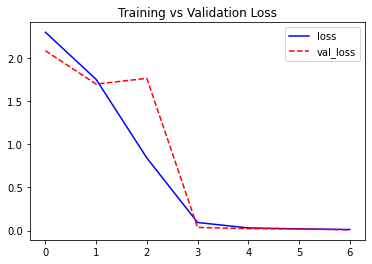

loss :  0.011564928106963634 val_loss :  0.0067846085876226425


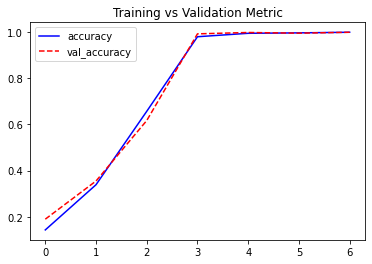

accuracy :  0.9981412887573242 val_accuracy :  0.998046875


In [12]:
model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', 
               metrics=['accuracy'])
tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(train_generator,
          validation_data = valid_generator,
          steps_per_epoch = train_generator.n//train_generator.batch_size,
          validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=7, callbacks=[tqdm_call, lr_call, stop_call])
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

# Test Time Augmentation
# This is an interesting part of inference using the trained model. Here instead of just using the given image for inference, we will use augmented images at the time of inference and average the results from all iterations in order to generate final inference.
# The level of augmentation of the test images was earlier defined under test_datagen

In [ ]:
tta_steps = 10
predictions = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(test_generator, steps = len(test_generator.filenames))
    predictions.append(preds)
preds = np.mean(predictions, axis=0)
preds = np.argmax(preds, axis=-1)
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('submission.csv', index=False)
!head submission.csv